In [115]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import keras_tuner as kt


from skimage.io import imread, imshow
from sklearn.metrics import  f1_score, precision_score, recall_score, jaccard_score

### Metrics functions

In [116]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)


### Data Preprocessing

In [117]:
def delete_blank_masks(path):
    for mask in tqdm(os.listdir(path + 'labels/')):
        mask_path = path + 'labels/' + mask
        mask = imread(mask_path)
        if np.sum(mask) == 0:
            print('Deleting', mask_path)
            print(mask_path.split('/')[-1])
            os.remove(mask_path)
            os.remove(path + 'images/' + mask_path.split('/')[-1])


def resize(input_image, input_mask, IMG_WIDTH, IMG_HEIGHT):
    input_image = tf.image.resize(input_image, (IMG_WIDTH, IMG_HEIGHT), method="nearest")
    input_mask = tf.image.resize(input_mask, (IMG_WIDTH, IMG_HEIGHT), method="nearest")
    input_mask = tf.image.rgb_to_grayscale(input_mask)
    return input_image, input_mask 

def augment(input_image, input_mask):
    is_flip = False
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        is_flip = True

    return input_image, input_mask, is_flip

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)
    input_image = input_image / 255.0
    input_mask = tf.cast(input_mask, tf.float32)
    input_mask = input_mask / 255.0
    return input_image, input_mask

In [118]:
# Params
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data_mod/train/'
TEST_PATH = 'data_mod/test/'

In [119]:
X_train = []
Y_train = []

# number of images in the train dataset
n_train = len(os.listdir(TRAIN_PATH+'images'))

# Load train images
for i in tqdm(range(n_train)):
    img = imread(TRAIN_PATH+'images/'+os.listdir(TRAIN_PATH+'images')[i])[:,:,:IMG_CHANNELS]
    mask = imread(TRAIN_PATH+'labels/'+os.listdir(TRAIN_PATH+'labels')[i])
    img, mask = resize(img, mask, IMG_WIDTH, IMG_HEIGHT)
    img, mask = normalize(img, mask)
    X_train.append(img)
    Y_train.append(mask)
    
    # Augment the data
    img, mask, is_flip = augment(img, mask)
    if is_flip:
        X_train.append(img)
        Y_train.append(mask)


X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train = (Y_train > 0.5).astype(int)

100%|██████████| 791/791 [00:39<00:00, 19.94it/s]


In [120]:
# Delete all blank masks if there are any
# delete_blank_masks(TRAIN_PATH)
print(X_train.shape)
print(Y_train.shape)

(1192, 128, 128, 3)
(1192, 128, 128, 1)


### Model - Original UNet


In [121]:
def original_double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    
    return x

In [122]:
def original_downsample_block(x, n_filters):
    # Double convolution followed by MaxPooling
    f = original_double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    return f, p

In [123]:
def original_upsample_block(x, conv_features, n_filters):
    # Upsample and concatenate
    x = tf.keras.layers.Conv2DTranspose(n_filters, 2, strides=2, padding="same")(x)
    x = tf.keras.layers.concatenate([x, conv_features])
    # Double convolution
    x = original_double_conv_block(x, n_filters)
    return x

In [66]:
def build_unet_original_model():
    # Input layer
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)  # Normalize inputs

    initial_filters = 64

    # Encoder
    c1, p1 = original_downsample_block(s, initial_filters)
    c2, p2 = original_downsample_block(p1, initial_filters * 2)
    c3, p3 = original_downsample_block(p2, initial_filters * 4)
    c4, p4 = original_downsample_block(p3, initial_filters * 8)

    # Bottleneck
    bn = original_double_conv_block(p4, initial_filters * 16)

    # Decoder
    u6 = original_upsample_block(bn, c4, initial_filters * 8)
    u7 = original_upsample_block(u6, c3, initial_filters * 4)
    u8 = original_upsample_block(u7, c2, initial_filters * 2)
    u9 = original_upsample_block(u8, c1, initial_filters)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(u9)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=bce_dice_loss,
        metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)]
    )

    return model

### Model - Modified UNet


In [124]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    
    return x

In [125]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)

    return f, p

In [126]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = tf.keras.layers.concatenate([x, conv_features])
    # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [127]:
def build_unet_model():
    # batch_size = hp.Choice("batch_size", [16, 32, 64])

    # Input layer
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalizing the inputs

    initial_filters = 16

    # Encoder
    c1, p1 = downsample_block(s, initial_filters)
    c2, p2 = downsample_block(p1, initial_filters*2)
    c3, p3 = downsample_block(p2, initial_filters*4)
    c4, p4 = downsample_block(p3, initial_filters*8)

    # Bottleneck
    bn = double_conv_block(p4, initial_filters*16)

    # Decoder
    u6 = upsample_block(bn, c4, initial_filters*8)
    u7 = upsample_block(u6, c3, initial_filters*4)
    u8 = upsample_block(u7, c2, initial_filters*2)
    u9 = upsample_block(u8, c1, initial_filters)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(u9)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # learning_rate = hp.Choice("learning_rate", [0.001, 0.0001])
    # optimizer_type = hp.Choice("optimizer", ["adam", "sgd", "rmsprop"])
    
    # if optimizer_type == "adam":
    #     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # elif optimizer_type == "sgd":
    #     optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    # elif optimizer_type == "rmsprop":
    #     optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=bce_dice_loss,
        metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)]  # Suas métricas
    )

    # model.hyperparameters = {
    #     'batch_size': batch_size,
    #     'optimizer': optimizer_type,
    #     'learning_rate': learning_rate
    # }
    
    
    return model

### Tuning

In [15]:
# class CustomModelCheckpoint(tf.keras.callbacks.Callback):
#     def on_train_end(self, logs=None):
#         # Get the trial's hyperparameters
#         trial_hyperparameters = self.model.hyperparameters
#         batch_size = trial_hyperparameters['batch_size']
#         optimizer = trial_hyperparameters['optimizer']
#         learning_rate = trial_hyperparameters['learning_rate']
        
#         # Define the file path
#         filepath = f"models/{batch_size}_{optimizer}_{learning_rate}_model.keras"
        
#         # Save the model
#         self.model.save(filepath)
#         print(f"Model saved to {filepath}")
class CustomBestModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, monitor="val_dice_coef", mode="max"):
        super(CustomBestModelCheckpoint, self).__init__()
        self.monitor = monitor
        self.mode = mode
        self.best = -float("inf") if mode == "max" else float("inf")
        self.monitor_op = tf.keras.backend.greater if mode == "max" else tf.keras.backend.less
    
    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        # Se o modelo melhorar a métrica monitorada
        if self.monitor_op(current, self.best):
            self.best = current

            # Obtenha os hiperparâmetros do modelo atual
            trial_hyperparameters = self.model.hyperparameters
            batch_size = trial_hyperparameters['batch_size']
            optimizer = trial_hyperparameters['optimizer']
            learning_rate = trial_hyperparameters['learning_rate']
            
            # Define o caminho com os hiperparâmetros no nome do arquivo
            filepath = f"models/best_model_{batch_size}_{optimizer}_{learning_rate}.keras"
            os.makedirs("models", exist_ok=True)  # Cria o diretório se não existir
            
            # Salva o melhor modelo atual
            self.model.save(filepath)
            print(f"Melhor modelo salvo para {filepath}")

In [16]:
# Criando o tuner
# tuner = kt.Hyperband(
#     build_unet_model,
#     objective=kt.Objective("val_dice_coef", direction="max"),  # Usando dice_coef
#     max_epochs=150,
#     factor=2,
#     directory="my_tuner_results_2",
#     project_name="unet_hyperparameter_tuning"
# )

tuner = kt.RandomSearch(
    build_unet_model,
    objective=kt.Objective("val_dice_coef", direction="max"),
    max_trials=20,
    directory="my_tuner_results",
    project_name="unet_hyperparameter_tuning"
)

# Executando a busca por hiperparâmetros
tuner.search(
    X_train, Y_train,
    validation_split=0.3,
    epochs=150,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10  # Use um valor fixo aqui
        ),
        tf.keras.callbacks.TensorBoard(log_dir="logs"),
        CustomBestModelCheckpoint(monitor="val_dice_coef", mode="max")
    ]
)

# Obtendo o melhor modelo encontrado
best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from my_tuner_results\unet_hyperparameter_tuning\tuner0.json



TypeError: build_unet_model() takes 0 positional arguments but 1 was given

In [ ]:
# Acessando todos os trials pelo tuner.oracle.trials
trials = tuner.oracle.trials

import pandas as pd

# Extrair dados dos trials em um DataFrame
trial_data = []
for trial_id, trial in trials.items():
    trial_data.append({
        "Trial ID": trial_id,
        "Hyperparameters": trial.hyperparameters.values,
        "Val Dice Coef": trial.score,
        "Status": trial.status
    })
pd.set_option('display.max_colwidth', None)  # Exibe o conteúdo completo de cada célula
df_trials = pd.DataFrame(trial_data)
df_sorted = df_trials.sort_values(by='Val Dice Coef', ascending=True)
df_sorted

,Trial ID,Hyperparameters,Val Dice Coef,Status
1,07,"{'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': 'sgd'}",0.025504,COMPLETED
7,09,"{'batch_size': 16, 'learning_rate': 0.001, 'optimizer': 'sgd'}",0.025506,COMPLETED
14,14,"{'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'sgd'}",0.025923,COMPLETED
16,16,"{'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'sgd'}",0.025933,COMPLETED
10,11,"{'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'sgd'}",0.027480,COMPLETED
8,10,"{'batch_size': 64, 'learning_rate': 0.0001, 'optimizer': 'sgd'}",0.027487,COMPLETED
0,01,"{'batch_size': 64, 'learning_rate': 0.0001, 'optimizer': 'rmsprop'}",0.080804,COMPLETED
2,05,"{'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': 'rmsprop'}",0.086995,COMPLETED
15,13,"{'batch_size': 16, 'learning_rate': 0.0001, 'optimizer': 'adam'}",0.137969,COMPLETED
5,00,"{'batch_size': 16, 'learning_rate': 0.001, 'optimizer': 'adam'}",0.536412,COMPLETED


### Fitting


In [128]:
# Params
BATCH_SIZE=64
EPOCHS=200
model = build_unet_model()
# original_unet = build_unet_original_model()
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=bce_dice_loss, metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)])

In [134]:
# training date - take the today's date
import datetime
today = datetime.date.today()
today = today.strftime("%Y-%m-%d")

#Checkpoint
file_path = "models/1final_model.keras"
file_path_original = "models/1final_model_unetoriginal.keras"
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, save_best_only=True, verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

# Train the model
results = model.fit(X_train, Y_train, validation_split=0.3, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)
# results = original_unet.fit(X_train, Y_train, validation_split=0.3, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.7350 - loss: 0.1561 - mean_io_u_2: 0.4937
Epoch 1: val_loss improved from inf to 0.23518, saving model to models/1final_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - dice_coef: 0.7350 - loss: 0.1564 - mean_io_u_2: 0.4937 - val_dice_coef: 0.6172 - val_loss: 0.2352 - val_mean_io_u_2: 0.4932
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.7233 - loss: 0.1637 - mean_io_u_2: 0.4939
Epoch 2: val_loss improved from 0.23518 to 0.22610, saving model to models/1final_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - dice_coef: 0.7246 - loss: 0.1632 - mean_io_u_2: 0.4938 - val_dice_coef: 0.6315 - val_loss: 0.2261 - val_mean_io_u_2: 0.4932
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef: 0.7475 - loss: 0.1487 - mean_io_u_2: 0.4937
Epoch 3: val_loss did not improve from 0.22610
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - dice_coef: 0.7459 - loss: 0.1489 - mean_io_u_2: 0.4937 - val_dice_coef: 0.608

### Plot the training results

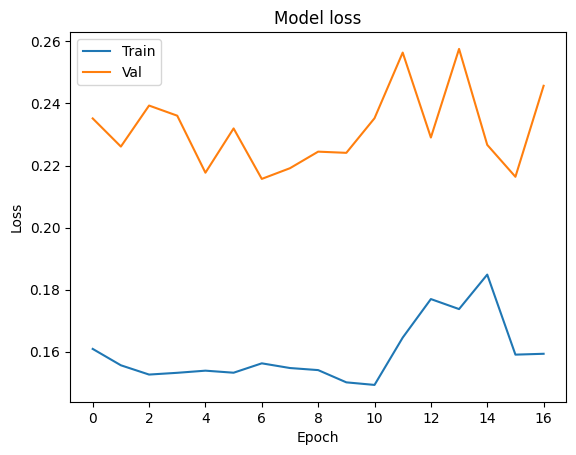

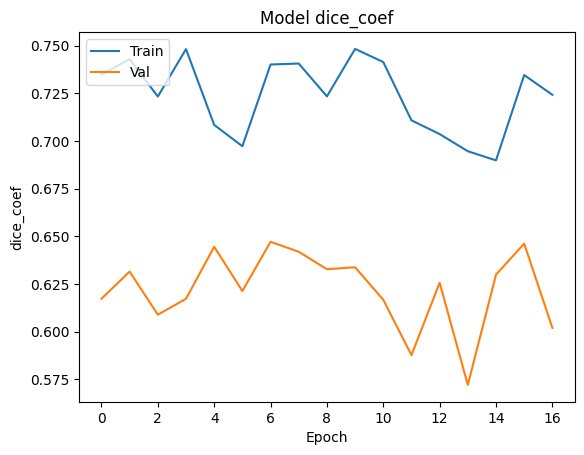

In [135]:
#Plot the training and validation loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#Plot the training and validation dice_coef
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Predictions

In [80]:
# Load the model
#{'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'adam'}
# {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
# {'batch_size': 64, 'learning_rate': 0.0001, 'optimizer': 'adam'}
model = tf.keras.models.load_model('models/1final_model_unetoriginal.keras', custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef}, safe_mode=False)

In [74]:
# Params
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
VAL_PATH = 'data_mod/validation/'

In [75]:
n_val = len(os.listdir(VAL_PATH+'images'))

X_val = []
Y_val = []

# Load val images
for i in tqdm(range(n_val)):
    img = imread(VAL_PATH+'images/'+os.listdir(VAL_PATH+'images')[i])[:,:,:IMG_CHANNELS]
    mask = imread(VAL_PATH+'labels/'+os.listdir(VAL_PATH+'labels')[i])
    img, mask = resize(img, mask, IMG_WIDTH, IMG_HEIGHT)
    img, mask = normalize(img, mask)
    X_val.append(img)
    Y_val.append(mask)


X_val = np.array(X_val)
Y_val = np.array(Y_val)
Y_val = (Y_val > 0.5).astype(int)

100%|██████████| 195/195 [00:04<00:00, 41.75it/s]


In [76]:
print(X_val.shape)
print(Y_val.shape)

(195, 128, 128, 3)
(195, 128, 128, 1)


In [136]:
# Predict on val
preds_val = model.predict(X_val, verbose=1)

# Threshold predictions
preds_val_t = (preds_val > 0.3).astype(np.uint8)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step


### Evaluate

In [137]:
dice_values = []
for ix in range(len(Y_val)):
    dice_value = dice_coef(Y_val[ix].flatten(), preds_val_t[ix].flatten()).numpy()  
    dice_values.append(dice_value)

dice_mean = np.mean(dice_values)



f1_values = []
for ix in range(len(Y_val)):
    f1_value = f1_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)
    f1_values.append(f1_value)

f1_mean = np.mean(f1_values)    

precision_values = []
for ix in range(len(Y_val)):
    precision_value = precision_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)
    precision_values.append(precision_value)

precision_mean = np.mean(precision_values)

recall_values = []
for ix in range(len(Y_val)):
    recall_value = recall_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)
    recall_values.append(recall_value)

recall_mean = np.mean(recall_values)

iou_values = []
for ix in range(len(Y_val)):
    iou_value = jaccard_score(Y_val[ix].flatten(), preds_val_t[ix].flatten())
    iou_values.append(iou_value)

iou_mean = np.mean(iou_values)
print('Dice:', dice_mean)   
print('F1:', f1_mean)
print('Precision:', precision_mean)
print('Recall:', recall_mean)
print('IoU:', iou_mean)


Dice: 0.5083406
F1: 0.49413587706422885
Precision: 0.5725703648333033
Recall: 0.5335109425944323
IoU: 0.39259546666794726


### Plot some results

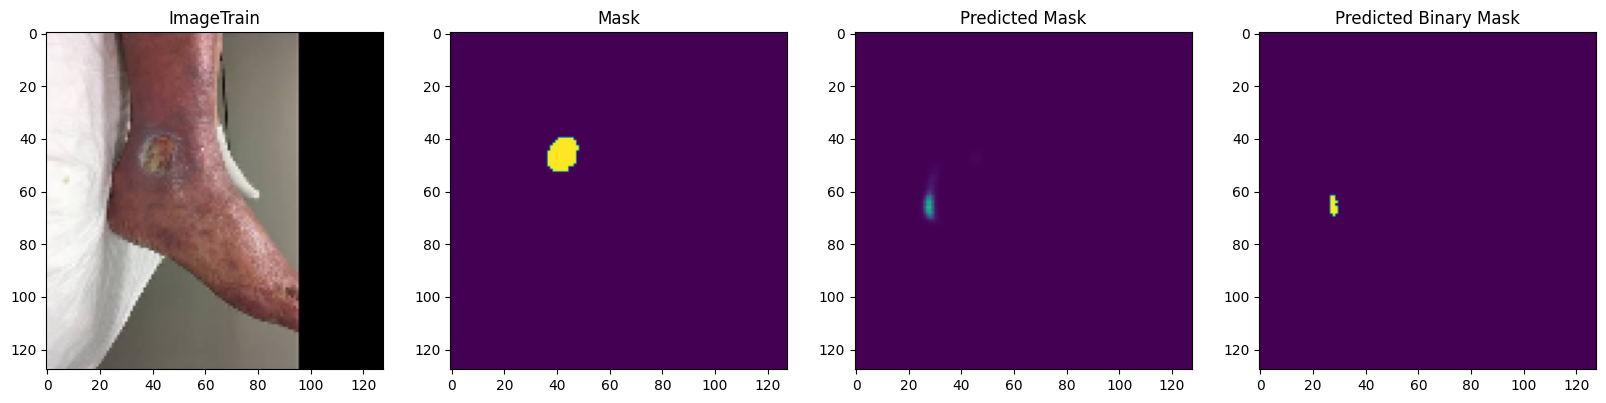

In [88]:
# Plot the results
def plot_sample(title, X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    ax[0].set_title('Image' + title)

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Predicted Mask')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Predicted Binary Mask')

# Check if training data looks all right
# ix for the image to be displayed, if None, a random image is displayed
# 171, 99 e 5
plot_sample("Train", X_val, Y_val, preds_val, preds_val_t, 5)

In [89]:
ix = 99

F1 score: 0.6883365200764818


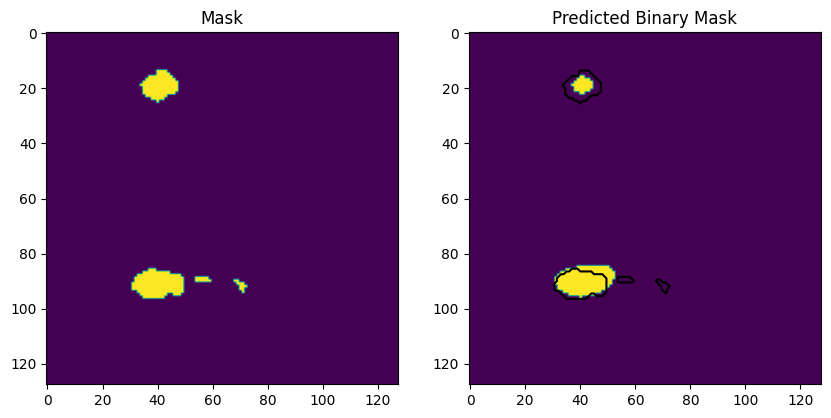

99


In [90]:
f1_value = f1_score(Y_val[ix].flatten(), preds_val_t[ix].flatten())
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(Y_val[ix].squeeze())
ax[1].imshow(preds_val_t[ix].squeeze())
ax[0].set_title('Mask')
ax[1].set_title('Predicted Binary Mask')
ax[1].contour(Y_val[ix].squeeze(), colors='k', levels=[0.5])
print("F1 score:", f1_value)
# Espera o usuário pressionar uma tecla para continuar
plt.show()
# ix= ix + 1
print(ix)

In [50]:
# # Mostra o que teve os top 5 valores de F1
f1_values = []
for ix in range(len(X_val)):
    f1_values.append([ix, f1_score(Y_val[ix].flatten(), preds_val_t[ix].flatten())])
    
f1_values.sort(key=lambda x: x[1], reverse=True)
print(f1_values[:5])

# # Mostra o que teve os top 5 piores valores de F1
f1_values.sort(key=lambda x: x[1], reverse=False)
print(f1_values[:5])

# # Mostra os top 5 valores medianos de f1
f1_values.sort(key=lambda x: x[1], reverse=False)
print(f1_values[round(len(f1_values)/2)-2:round(len(f1_values)/2)+3])

[[69, 0.9738717339667459], [98, 0.9392446633825944], [73, 0.9309576837416481], [179, 0.9295539808253439], [148, 0.925459825750242]]
[[5, 0.0], [10, 0.0], [15, 0.0], [20, 0.0], [34, 0.0]]
[[78, 0.6794871794871795], [93, 0.68], [12, 0.6822742474916388], [44, 0.684931506849315], [99, 0.6883365200764818]]
